In [ ]:
import cv2
import numpy as np
import scipy
from google.colab.patches import cv2_imshow
import gc
import torch
import os

In [ ]:
def image_compression(image_file):
  '''
  double horizontal and vertical file compression using cubic interpolation,
  colour inversion
  '''
  output_image = np.where(image_file >= 0, 255-image_file, image_file)
  resized_img = cv2.resize(output_image, (int(output_image.shape[1]/2), int(output_image.shape[0]/2)), interpolation=cv2.INTER_CUBIC)
  return resized_img

In [ ]:
def image_to_X_matrix(image_array):
  '''
  Converting image_array into torch.sparse_coo_tensor
  '''
  image_array_uint8 = np.array(image_array, dtype=np.uint8)
  image_flat = image_array_uint8.flatten()
  nonzero_indices = np.where(image_flat != 0)[0]
  nonzero_values = image_flat[nonzero_indices]
  X = torch.sparse_coo_tensor(torch.tensor([nonzero_indices]), torch.tensor(nonzero_values, dtype=torch.uint8), (image_flat.size,))
  return X

In [ ]:
img_name = '001c.inkml.png'
img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)

Before transformation :

Shape = (1948, 2579)

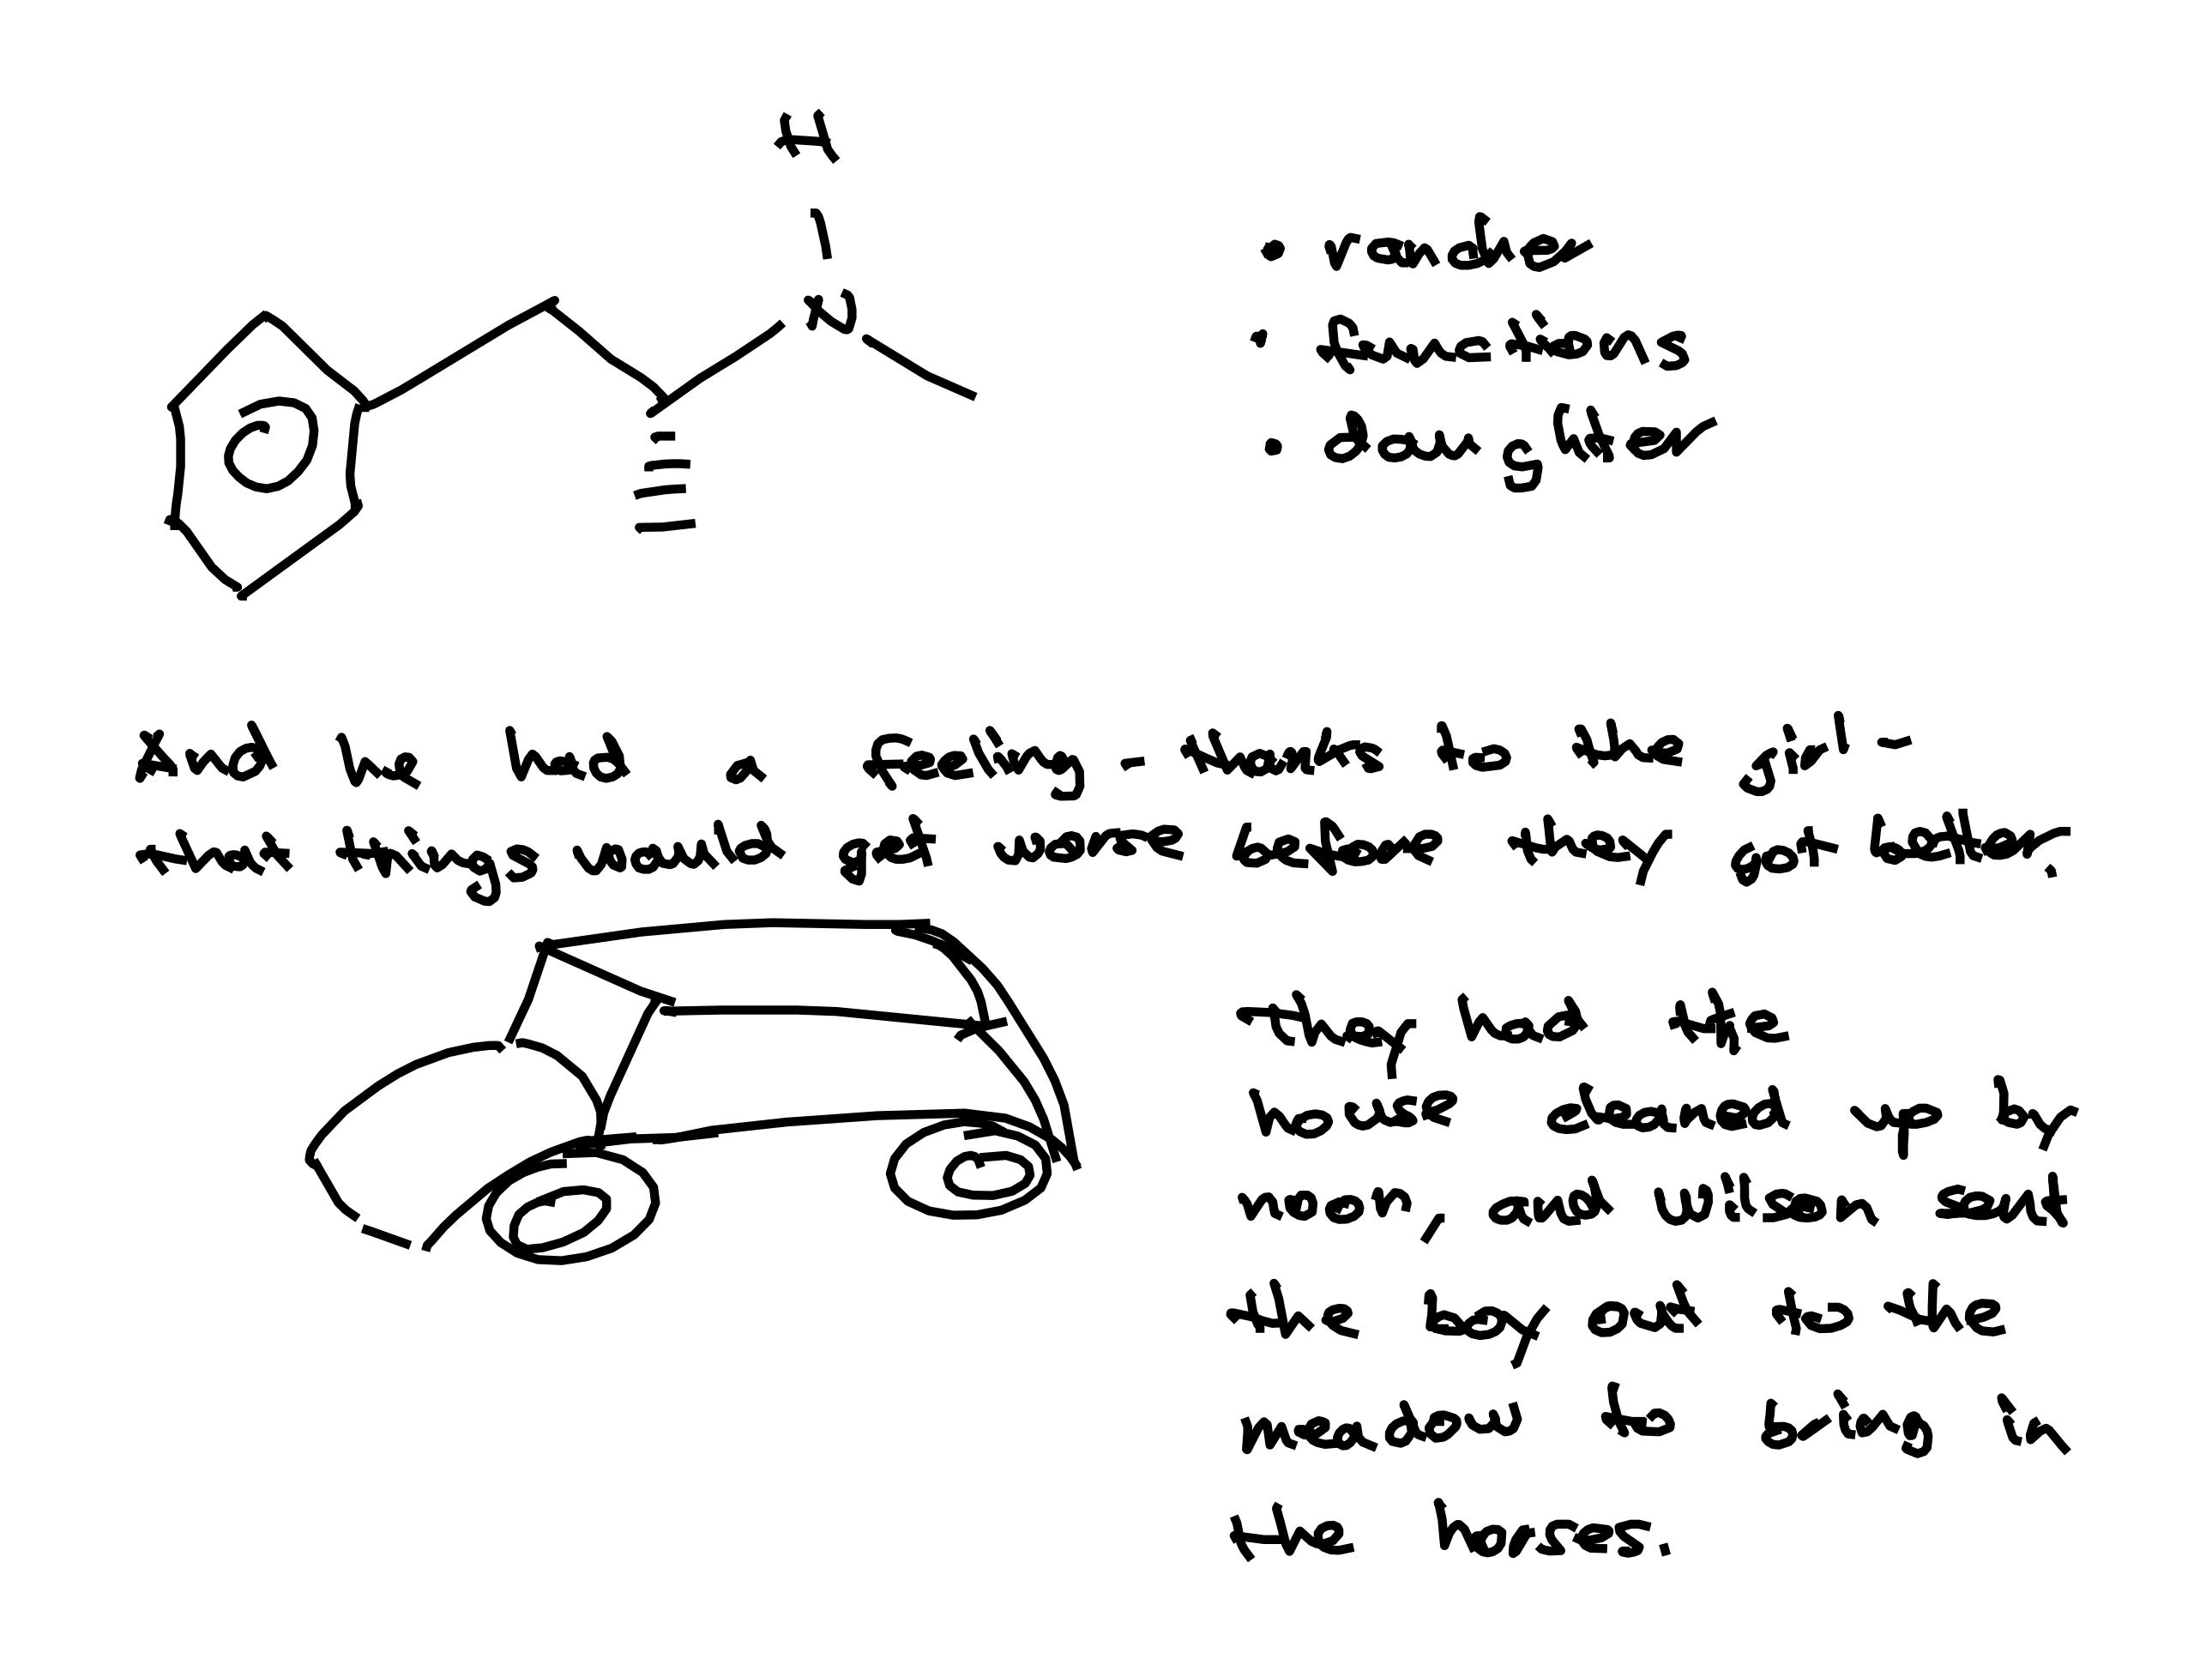

In [ ]:
res_img = image_compression(img)

After transformation :

Shape = (974, 1289)

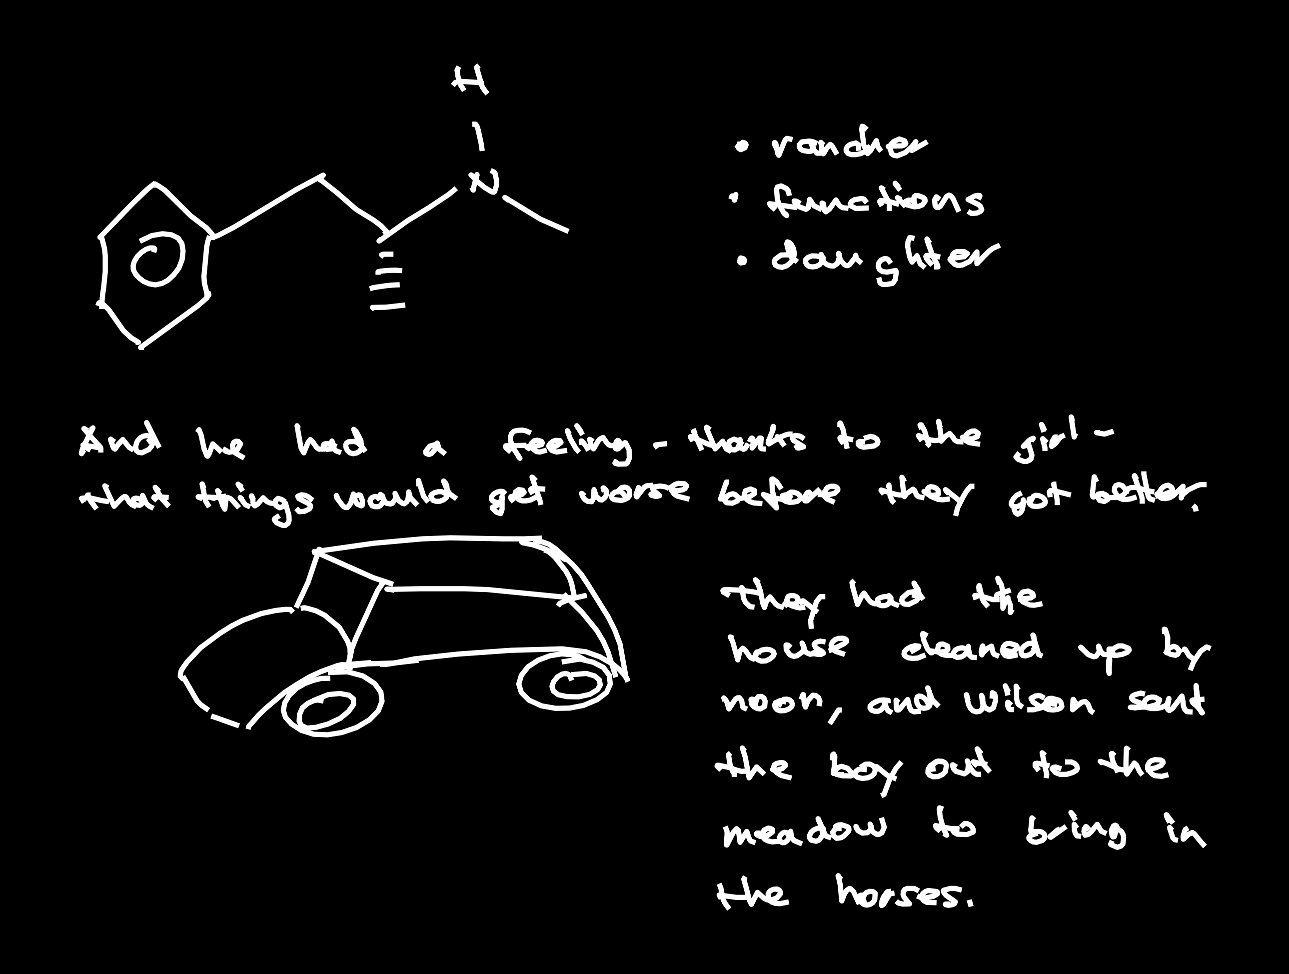

In [ ]:
def image_to_adjacency_matrix_opt(image_array, nodata = None):
    '''
    Creating adjacency matrix for images
    '''
    image_flat = image_array.flatten()

    height, width = image_array.shape
    N = height * width
    image_has_data = image_flat != nodata
    index_dtype = np.int32 if N < 2 ** 31 else np.int64
    adjacents = np.array([
        -width - 1, -width, -width + 1,
        -1,      0,           1,
        width - 1,  width,  width + 1
    ], dtype=index_dtype)
    row_idx, col_idx = np.meshgrid(
        np.arange(1, height - 1, dtype=index_dtype),
        np.arange(1, width - 1, dtype=index_dtype),
        indexing='ij'
    )
    row_idx = row_idx.reshape(-1)
    col_idx = col_idx.reshape(-1)
    pixel_idx = row_idx * width + col_idx
    pixels_with_data = image_has_data[pixel_idx]
    pixel_idx = pixel_idx[pixels_with_data]
    neighbors = pixel_idx.reshape(-1, 1) + adjacents.reshape(1, -1)
    neighbors_with_data = image_has_data[neighbors]
    row = np.repeat(pixel_idx, repeats=neighbors_with_data.sum(axis=1))
    col = neighbors[neighbors_with_data]
    data = np.ones(len(row), dtype='uint8')
    torch_sparse_tensor = torch.sparse_coo_tensor(torch.tensor([row, col]), torch.tensor(data), torch.Size((N, N)))
    return torch_sparse_tensor

In [ ]:
A_hat = image_to_adjacency_matrix_opt(res_img)

In [ ]:
torch.save(A_hat, '/content/drive/MyDrive/Colab_Notebooks/CV_handwriting/lamono_tesnors/A_hat.pt')

In [ ]:
for root, dirs, files in os.walk("/content/drive/MyDrive/Colab_Notebooks/CV_handwriting/lamono_my_render"):
    for filename in files:
      print(filename)
      img = cv2.imread("/content/drive/MyDrive/Colab_Notebooks/CV_handwriting/lamono_my_render/"+filename, cv2.IMREAD_GRAYSCALE)
      res_img = image_compression(img)
      X = image_to_X_matrix(res_img)
      torch.save(X, '/content/drive/MyDrive/Colab_Notebooks/CV_handwriting/lamono_tesnors/'+filename[:-10]+'.pt')